# Exponentially-Weighted Means and Covariances

The purpose of this notebook is to illustrate and discuss implementations of exponentially-weighted calculations for important measures in risk management, portfolio construction & asset allocation and many other related fields. The code provided is for educational purposes and not optimized for productive purposes.

First, we load some basic Python libraries. The less, the better.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Then we define a function for the exponentially-weighted calculations. Note that means and covariances are being calculated together, such that  unnecessary loops and repeats are minimized.

In [2]:
def apa_ew_mean_and_cov(X, lambd):
    """
    Returns (mean_vector, covariance_matrix) using exponentially weighted statistics. The most recent obs is last observations, i.e. X[-1].
    X:  (n_obs x n_assets) of type dataframe
    lambd: decay parameter (0 < lambd < 1).
    """
    X = np.asarray(X)
    n_obs = X.shape[0]
    weights = (1 - lambd) * (lambd ** np.arange(n_obs)[::-1])
    weights = weights / weights.sum()   # This makes the weights sum up to 1 in finite samples.
    mean_ew = np.sum(weights[:, None] * X, axis=0)
    X_centered = X - mean_ew
    cov_ew = (X_centered * weights[:, None]).T @ X_centered
    return mean_ew, cov_ew

Theoretically, weights only converge to 1 if sample size converges to infinity. In the above code, we standardise the weights such that their sum adds to one in a dataset of finite size. Depending on what you do with this function result, you might be interested in commenting out the standardisation. Further explanations will be given here at a later point.

Let us load some data in a pandas dataframe object now.

In [3]:
returns = pd.read_csv("data.csv", index_col=0, parse_dates=True)

We can check how many time series we have in this dataset.

In [4]:
n_assets = returns.shape[1]
print(n_assets)

30


And let us see how many observations we have.

In [5]:
n_obs = returns.shape[0]
print(n_obs)

487


Exponential weighing schemes require a parameter which determines the decay of the exponential weights. This parameter is either expressed as a half-life or a lambda value. A lambda value of 0.94 is a popular choice. This has historical reasons that we might discuss here in the future.

In [6]:
lambd = 0.94

The reason for this rather odd name in the Python code is that "lambda" is a reserved keyword which stands for very different purposes in Python.

Anyway, let us now pass the input data and parameter value to the above function, and let the function do its work.

In [7]:
mean_vector, cov_matrix = apa_ew_mean_and_cov(returns, lambd)

The results are a vector of mean returns

In [8]:
print(mean_vector.shape)

(30,)


And a matrix of covariances.

In [9]:
print(cov_matrix.shape)

(30, 30)


For comparison purposes, we now calculated the equal-weighted mean vector and covariance matrix.

In [10]:
# Equal-weighted (arithmetic) measures
mean_eq = np.mean(returns, axis=0)
vol_eq = np.std(returns, axis=0, ddof=0)
corr_eq = np.corrcoef(returns, rowvar=False)
avg_corr_eq = (np.sum(corr_eq, axis=1) - 1) / (n_assets - 1)

The code below formats the function results and the equally-weighted results such that they can be visualized in three bar plots below this code block.

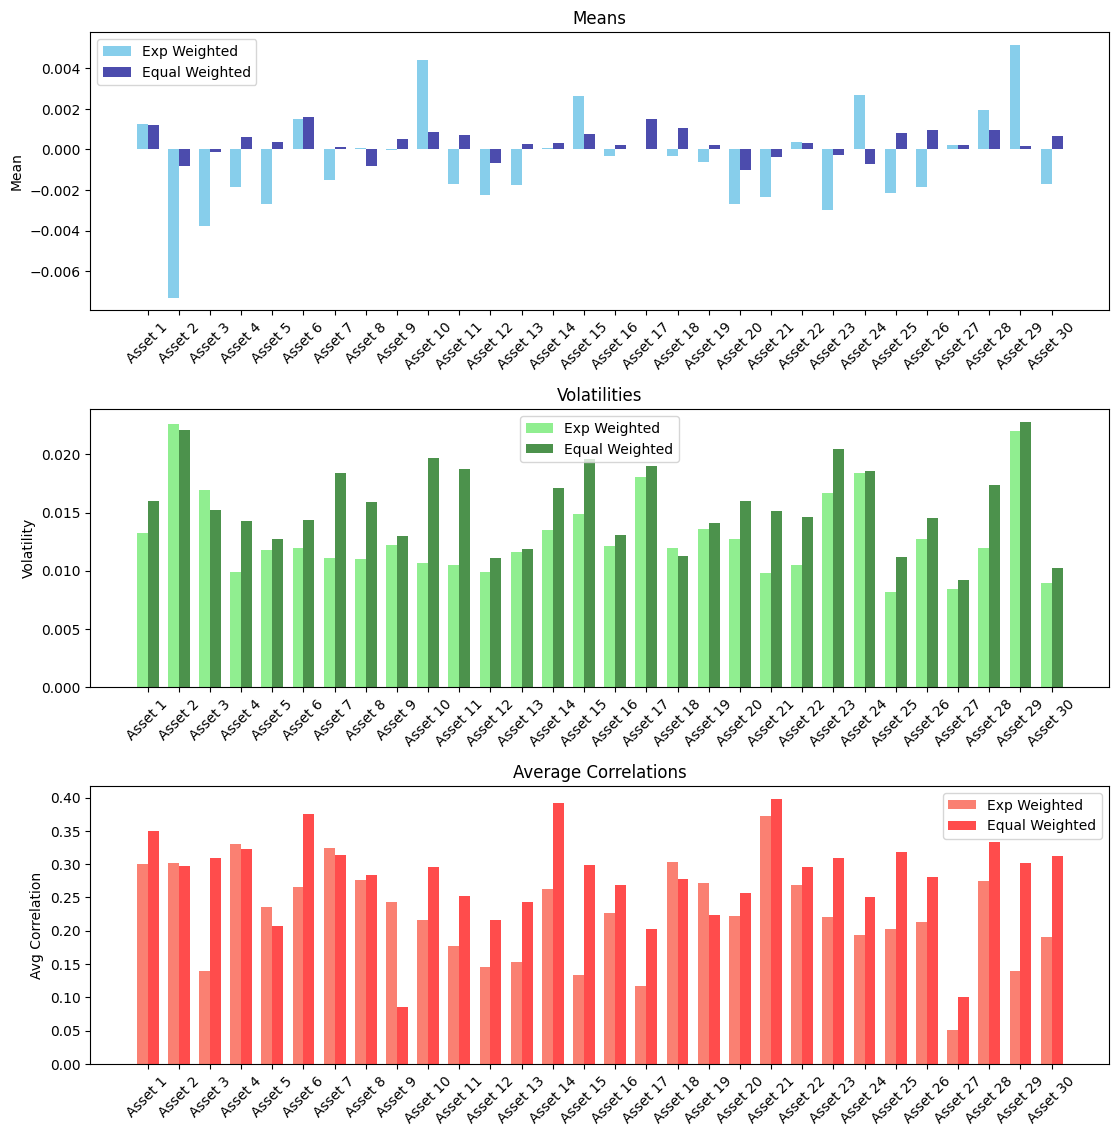

In [11]:
# Asset names setup
asset_names = [f'Asset {i+1}' for i in range(n_assets)]

# Extract exponentially-weighted volatilities (standard deviations)
volatilities = np.sqrt(np.diag(cov_matrix))

# Extract exponentially-weighted correlations
stddev = np.sqrt(np.diag(cov_matrix))
corr_matrix = cov_matrix / np.outer(stddev, stddev)
avg_correlations = (np.sum(corr_matrix, axis=1) - 1) / (len(asset_names) - 1)

x = np.arange(len(asset_names))
width = 0.35  # width of the bars

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.tight_layout(pad=5.0)

# Means
axs[0].bar(x - width/2, mean_vector, width=width, color='skyblue', label='Exp Weighted')
axs[0].bar(x + width/2, mean_eq, width=width, color='darkblue', alpha=0.7, label='Equal Weighted')
axs[0].set_title('Means')
axs[0].set_ylabel('Mean')
axs[0].set_xticks(x)
axs[0].set_xticklabels(asset_names, rotation=45)
axs[0].legend()

# Volatilities
axs[1].bar(x - width/2, volatilities, width=width, color='lightgreen', label='Exp Weighted')
axs[1].bar(x + width/2, vol_eq, width=width, color='darkgreen', alpha=0.7, label='Equal Weighted')
axs[1].set_title('Volatilities')
axs[1].set_ylabel('Volatility')
axs[1].set_xticks(x)
axs[1].set_xticklabels(asset_names, rotation=45)
axs[1].legend()

# Average Correlations
axs[2].bar(x - width/2, avg_correlations, width=width, color='salmon', label='Exp Weighted')
axs[2].bar(x + width/2, avg_corr_eq, width=width, color='red', alpha=0.7, label='Equal Weighted')
axs[2].set_title('Average Correlations')
axs[2].set_ylabel('Avg Correlation')
axs[2].set_xticks(x)
axs[2].set_xticklabels(asset_names, rotation=45)
axs[2].legend()

plt.show()


A possible use case for these results is traditional mean-variance optimization. Maybe we illustrate this at one point in this notebook.